In [1]:
# notebook to load the raw govt (CPCB/DPCC/IMD) data in the Excel sheet format and save them as csvs with latitude 
# and longitude fields

%matplotlib inline

from glob import glob
from openpyxl import Workbook
from openpyxl import load_workbook
import json
from datetime import datetime
from datetime import timedelta
import time
import os, sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load all the Excel sheets from the source folder on Dropbox

suffix = '1H_May2018_Feb2020'
#sheets = sorted(glob('data/govdata/*.xlsx'), key=lambda name: int(name.split('/data')[1].replace('.xlsx','')))
#sheets = sorted(glob('/home/shivar/Dropbox/Delhi Pollution/07_Data_Secondary/CPCB/Raw/*.xlsx'))
fileslist = glob('/home/shivar/Dropbox/Delhi Pollution/07_Data_Secondary/CPCB/Raw/*_{}.xlsx'.format(suffix))
fileslist.sort()
for fpath in fileslist:
    print(os.path.basename(fpath))

AnandVihar_DPCC_1H_May2018_Feb2020.xlsx
AshokVihar_DPCC_1H_May2018_Feb2020.xlsx
AyaNagar_IMD_1H_May2018_Feb2020.xlsx
BurariCrossing_IMD_1H_May2018_Feb2020.xlsx
CRRIMathuraRoad_IMD_1H_May2018_Feb2020.xlsx
DKSSR_DPCC_1H_May2018_Feb2020.xlsx
DTU_CPCB_1H_May2018_Feb2020.xlsx
DwarkaSector8_DPCC_1H_May2018_Feb2020.xlsx
EastArjunNagar_CPCB_1H_May2018_Feb2020.xlsx
IGIAirport_IMD_1H_May2018_Feb2020.xlsx
IHBAS_CPCB_ITO_CPCB_1H_May2018_Feb2020.xlsx
Jahangirpuri_DPCC_JNS_DPCC_1H_May2018_Feb2020.xlsx
LodhiRoad_IMD_MandirMarg_DPCC_1H_May2018_Feb2020.xlsx
MDCNS_DPCC_Mundaka_DPCC_1H_May2018_Feb2020.xlsx
NSIT_CPCB_OkhlaPhase2_DPCC_1H_May2018_Feb2020.xlsx
NehruNagar_DPCC_NorthCampusDU_IMD_1H_May2018_Feb2020.xlsx
Patparganj_DPCC_PunjabiBagh_DPCC_1H_May2018_Feb2020.xlsx
Pusa_DPCC_Pusa_IMD_1H_May2018_Feb2020.xlsx
RKPuram_DPCC_Rohini_DPCC_1H_May2018_Feb2020.xlsx
Shadipur_CPCB_Sirifort_CPCB_1H_May2018_Feb2020.xlsx
SoniaVihar_DPCC_SriAurobindoMarg_DPCC_1H_May2018_Feb2020.xlsx
VivekVihar_DPCC_Wazirpur_DPCC_1H_

In [10]:
import pandas as pd

# handy conversion function to handle missing values
def myconv(strval):
    if strval=='None' or strval==None:
        return np.nan
    else:
        return float(strval)

# read data for an excel file and return a list of dataframes, 
# one for each monitor in the file
def read_xlsx(fpath):
    workbook = load_workbook(fpath)
    sheet = workbook['Sheet1']
    fname = os.path.basename(fpath)
    
    ROW_START = 14
    rr = ROW_START
    
    # the sheet may have data from multiple sensors, so the outer
    # loop iterates through the monitors, the inner loop iterates 
    # through rows
    parts = fname[:fname.find('_' + suffix)].split('_')
    n_monitors = len(parts)//2
    
    print('Number of monitors:', n_monitors)
    
    data_list = []
    
    count = 0
    while count < len(parts):
        name = '{}_{}'.format(parts[count], parts[count+1])
        
        if name != 'NorthCampusDU_IMD':
            data = []
            
            print('Reading data for', name)
            while True:
                date = sheet.cell(rr, 1).value
                if date is None or len(date) == 1:
                    break
                at = myconv(sheet.cell(rr, 3).value)
                pm10 = myconv(sheet.cell(rr, 4).value)
                pm25 = myconv(sheet.cell(rr, 5).value)
                wd = myconv(sheet.cell(rr, 6).value)
                ws = myconv(sheet.cell(rr, 7).value)
                rh = myconv(sheet.cell(rr, 8).value)
                
                # to re-format the date and time in the same format as the Kaiterra dts
                dobj = datetime.strptime(date, '%d-%m-%Y %H:%M')
                dobj = pd.Timestamp(dobj, tz='Asia/Kolkata')
                data.append([dobj, pm25, pm10, at, rh, wd, ws])
                rr += 1
            
            dtindex = [ent[0] for ent in data]
            # valarr = np.asarray([(latitude, longitude, locname, ent[1], ent[2]) for ent in data])
            # df = pd.DataFrame(valarr, index=dtindex, columns=['latitude', 'longitude', 'location', 'pm25', 'pm10'])
            #df = pd.DataFrame(valarr, index=dtindex, columns=['pm25', 'pm10'])
            df = pd.DataFrame([ent[1:] for ent in data], index=dtindex, columns=['pm25', 'pm10', 'AT', 'RH', 'WD', 'WS'])
            df.index.name = 'timestamp_round'
            
            data_list.append((name, df))
        
        rr += 2
        count += 2
    
    return data_list

In [11]:
data_list = read_xlsx(fileslist[-1])

Number of monitors: 2
Reading data for VivekVihar_DPCC
Reading data for Wazirpur_DPCC


In [12]:
print(len(data_list))

for name, data in data_list:
    print(name, data.shape)
    print(data.iloc[0,:])
    print(data.iloc[-1,:])

2
VivekVihar_DPCC (15433, 6)
pm25     78.00
pm10    173.50
AT       29.90
RH       47.08
WD      169.92
WS        0.17
Name: 2018-04-30 00:00:00+05:30, dtype: float64
pm25    132.00
pm10    223.00
AT       11.25
RH       93.20
WD      285.85
WS        0.30
Name: 2020-02-02 00:00:00+05:30, dtype: float64
Wazirpur_DPCC (15433, 6)
pm25     92.00
pm10    315.00
AT       32.04
RH       39.08
WD      212.42
WS        0.77
Name: 2018-04-30 00:00:00+05:30, dtype: float64
pm25    219.00
pm10    395.00
AT       11.15
RH       91.05
WD      309.30
WS        1.10
Name: 2020-02-02 00:00:00+05:30, dtype: float64


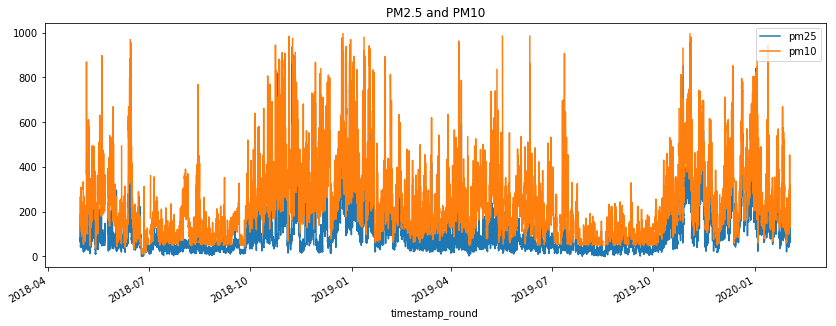

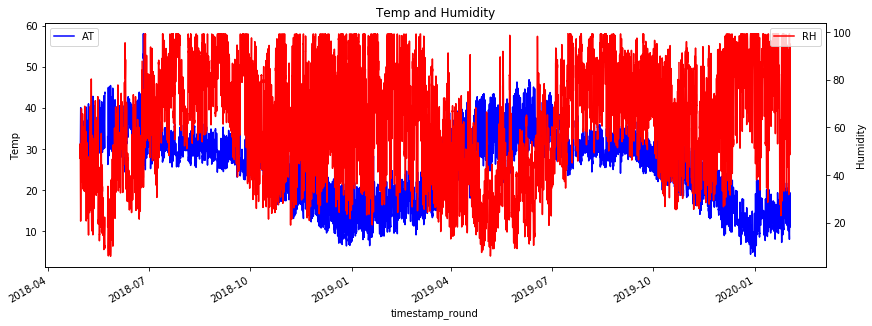

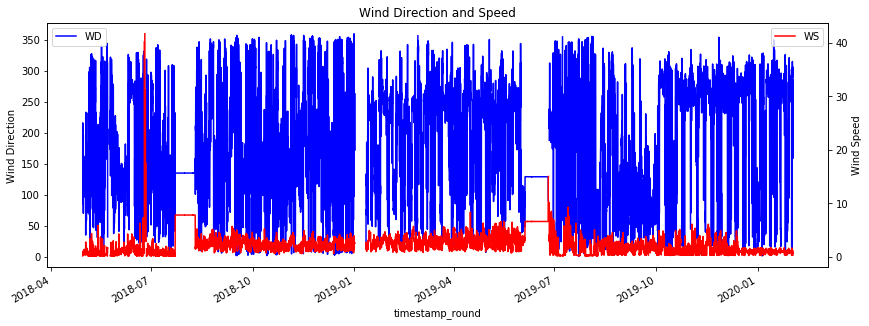

In [13]:
# sample plot of the data as an example illustration
name, df = data_list[0]

plt.figure(figsize=(14, 5))
plt.title('PM2.5 and PM10')
df.pm25.plot(ax=plt.gca())
df.pm10.plot(ax=plt.gca())
plt.legend()

plt.figure(figsize=(14, 5))
plt.title('Temp and Humidity')
df.AT.plot(ax=plt.gca(), c='b')
plt.ylabel('Temp')
plt.legend(loc=2)
plt.twinx()
df.RH.plot(ax=plt.gca(), c='r')
plt.ylabel('Humidity')
plt.legend(loc=1)

plt.figure(figsize=(14, 5))
plt.title('Wind Direction and Speed')
df.WD.plot(ax=plt.gca(), c='b')
plt.ylabel('Wind Direction')
plt.legend(loc=2)
plt.twinx()
df.WS.plot(ax=plt.gca(), c='r')
plt.ylabel('Wind Speed')
plt.legend(loc=1)

plt.show()
plt.close('all')

In [9]:
# import json

# # reading in the metadata to get the latitudes and longitudes
# locsdict = dict()

# with open('data/gov_metadata.json')as fl:
#     stations = json.load(fl)

# for station in stations['map']['station_list']:
#     nm = station['station_name']
#     locsdict[nm] = (float(station['latitude']), float(station['longitude']))

In [10]:
# print(len(locsdict))
# locsdict

In [11]:
# # correct errors (see notes.txt in the same folder as this notebook)
# # (1) remove DU north campus
# # (2) swap RK Puram and Punjabi Bagh locations
# locsdict.__delitem__('North Campus, DU, New Delhi - IMD')
# locsdict['Punjabi Bagh, Delhi - DPCC'] = (28.674045, 77.131023)
# locsdict['R K Puram, New Delhi - DPCC'] = (28.563262, 77.186937)

In [16]:
# saving individual dataframes as individual csvs, and also saving a combined BIG csv

# also save the locations
#locs_list = []

dfs_list = []

start_dt = pd.Timestamp('2018-05-01', tz='Asia/Kolkata')
end_dt = pd.Timestamp('2020-02-01', tz='Asia/Kolkata')

newsuffix = '1H_{}_{}'.format(start_dt.strftime('%Y%m%d'), end_dt.strftime('%Y%m%d'))

savedir = '../data/govdata/'
subsavedir = os.path.join(savedir, 'govdata_' + newsuffix)
if not os.path.exists(subsavedir):
    os.makedirs(subsavedir)

# for fii, fpath in enumerate(sheets):
#for fii in range(0, len(sheets), 2):
for fii, fpath in enumerate(fileslist):
    #fpath = sheets[fii]
    #savedir, savename = os.path.split(fpath)
    #monitorid = os.path.splitext(savename)[0]
    #print('{}/{} {}'.format(fii//2 + 1, len(sheets)//2, monitorid))
    print('{}/{} {}'.format(fii + 1, len(fileslist), os.path.basename(fpath)))
    
    #sheet1 = load_workbook(fpath)
    #df1 = todf(sheet1['Sheet1'])
    
    #heet2 = load_workbook(fpath.replace(monitorid, monitorid + '_cont'))
    #df2 = todf(sheet2['Sheet1'])
    
    #df = pd.concat([df1.iloc[22:], df2])
    
    data_list = read_xlsx(fpath)
    
    for monitorid, df in data_list:
        df = df.loc[slice(start_dt, end_dt),:]
        df = df.iloc[:-1] # for some reason the first row for Feb 1, 2020 is getting included, hence removing that
        df.to_csv(os.path.join(subsavedir, monitorid + '.csv'))
        
        df['monitor_id'] = monitorid
        df.reset_index(inplace=True)
        df.set_index(['monitor_id', 'timestamp_round'], inplace=True)
        # locs_list.append((monitorid, df.latitude[0], df.longitude[0], df.location[0]))
        # df.drop(axis=1, labels=['latitude', 'longitude', 'location'], inplace=True)
        dfs_list.append(df)
        #savename = 'govdata_15min_' + monitorid + '.csv

#pd.concat(dfs_list).to_csv(os.path.join(savedir, 'govdata_15min_panel.csv'))
pd.concat(dfs_list).to_csv(os.path.join(savedir, 'govdata_{}.csv'.format(newsuffix)))

1/22 AnandVihar_DPCC_1H_May2018_Feb2020.xlsx
Number of monitors: 1
Reading data for AnandVihar_DPCC
2/22 AshokVihar_DPCC_1H_May2018_Feb2020.xlsx
Number of monitors: 1
Reading data for AshokVihar_DPCC
3/22 AyaNagar_IMD_1H_May2018_Feb2020.xlsx
Number of monitors: 1
Reading data for AyaNagar_IMD
4/22 BurariCrossing_IMD_1H_May2018_Feb2020.xlsx
Number of monitors: 1
Reading data for BurariCrossing_IMD
5/22 CRRIMathuraRoad_IMD_1H_May2018_Feb2020.xlsx
Number of monitors: 1
Reading data for CRRIMathuraRoad_IMD
6/22 DKSSR_DPCC_1H_May2018_Feb2020.xlsx
Number of monitors: 1
Reading data for DKSSR_DPCC
7/22 DTU_CPCB_1H_May2018_Feb2020.xlsx
Number of monitors: 1
Reading data for DTU_CPCB
8/22 DwarkaSector8_DPCC_1H_May2018_Feb2020.xlsx
Number of monitors: 1
Reading data for DwarkaSector8_DPCC
9/22 EastArjunNagar_CPCB_1H_May2018_Feb2020.xlsx
Number of monitors: 1
Reading data for EastArjunNagar_CPCB
10/22 IGIAirport_IMD_1H_May2018_Feb2020.xlsx
Number of monitors: 1
Reading data for IGIAirport_IMD
11/

In [16]:
savedir

'/home/shivar/Dropbox/Delhi Pollution/07_Data_Secondary/CPCB_Oct2018/Raw'

In [20]:
locs_list

[('AnandVihar_DPCC', 28.646835, 77.316032, 'Anand Vihar, Delhi - DPCC'),
 ('AshokVihar_DPCC', 28.695381, 77.181665, 'Ashok Vihar, Delhi - DPCC'),
 ('AyaNagar_IMD', 28.4706914, 77.1099364, 'Aya Nagar, New Delhi - IMD'),
 ('BurariCrossing_IMD',
  28.7256504,
  77.2011573,
  'Burari Crossing, New Delhi - IMD'),
 ('CRRIMathuraRoad_IMD',
  28.5512005,
  77.2735737,
  'CRRI Mathura Road, New Delhi - IMD'),
 ('DKSSR_DPCC',
  28.498571,
  77.26484,
  'Dr. Karni Singh Shooting Range, Delhi - DPCC'),
 ('DTU_CPCB', 28.7500499, 77.1112615, 'DTU, New Delhi - CPCB'),
 ('DwarkaSector8_DPCC',
  28.5710274,
  77.0719006,
  'Dwarka-Sector 8, Delhi - DPCC '),
 ('EastArjunNagar_CPCB',
  28.6556017,
  77.2859318,
  'East Arjun Nagar, Delhi - CPCB'),
 ('IGIAirport_IMD',
  28.5627763,
  77.1180053,
  'IGI Airport (T3), New Delhi - IMD'),
 ('IHBAS_CPCB',
  28.6811736,
  77.3025234,
  'IHBAS, Dilshad Garden,New Delhi - CPCB'),
 ('ITO_CPCB', 28.6316945, 77.2494387, 'ITO, New Delhi - CPCB'),
 ('JNS_DPCC', 28.580

In [18]:
# colnames = ['Monitor ID', 'Latitude', 'Longitude', 'Location']
# collen_0 = max([len(colnames[0])] + [len(tup[0]) for tup in locs_list]) + 1
# collen_1 = max([len(colnames[1])] + [len(str(tup[1])) for tup in locs_list]) + 1
# collen_2 = max([len(colnames[2])] + [len(str(tup[2])) for tup in locs_list]) + 1

# fout = open(os.path.join(savedir, 'govdata_locations.csv'), 'w')
# fout.write('{{:{}}},{{:>{}}},{{:>{}}}, {{}}\n'.format(collen_0, collen_1, collen_2).format(*colnames))

# for locid, lat, lon, locname in locs_list:
#     fout.write('{{:{}}},{{:>{}}},{{:>{}}}, {{}}\n'.format(collen_0, collen_1, collen_2).format(locid, str(lat), str(lon), '"' + locname + '"'))
# fout.close()

In [28]:
# create dataframe and export to csv (above does not work)
locs_df = pd.DataFrame.from_records(locs_list, columns=['Monitor ID', 'Latitude', 'Longitude', 'Location'])
locs_df.set_index('Monitor ID', inplace=True)
locs_df

,Latitude,Longitude,Location
Monitor ID,,,
AnandVihar_DPCC,28.646835,77.316032,"Anand Vihar, Delhi - DPCC"
AshokVihar_DPCC,28.695381,77.181665,"Ashok Vihar, Delhi - DPCC"
AyaNagar_IMD,28.470691,77.109936,"Aya Nagar, New Delhi - IMD"
BurariCrossing_IMD,28.725650,77.201157,"Burari Crossing, New Delhi - IMD"
CRRIMathuraRoad_IMD,28.551201,77.273574,"CRRI Mathura Road, New Delhi - IMD"
DKSSR_DPCC,28.498571,77.264840,"Dr. Karni Singh Shooting Range, Delhi - DPCC"
DTU_CPCB,28.750050,77.111261,"DTU, New Delhi - CPCB"
DwarkaSector8_DPCC,28.571027,77.071901,"Dwarka-Sector 8, Delhi - DPCC"
EastArjunNagar_CPCB,28.655602,77.285932,"East Arjun Nagar, Delhi - CPCB"


In [29]:
locs_df.to_csv(os.path.join(savedir, 'govdata_locations.csv'))